In [10]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [11]:
from config import *
from encoder import *
from decoder import *
from data import *
from vital import *
from train import *
from eval import *
from augmentor import *
from describer import *
from masker import *
print("using device: ", device)
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# import pkg_resources
# print(pkg_resources.get_distribution('python-calamine').version)



using device:  cpu


In [12]:
# ---- (customize) update configs ----
overwrite = True
model_name = 'testtest'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['split'] = True
text_config['demo']['gre'] = True
text_config['demo']['apgar_mage'] = True
model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    model_name = model_name,
    ts_aug = False,
    ts_subseq = False,
    ts_augsub = False,
    balance = False,
    block_target = False,
    embedded_dim = 128,
    batch_size = 2048, # larger batch 
    patience = 30,
    num_saves = 20,
    num_epochs = 1,
    downsample_size = 300,
    text_config = text_config,
    text_col_ls = ['cl_event', 'ts_description', 'demo_ga', 'demo_weight', 'demo_apgar', 'demo_mother']
)
config_dict = get_config_dict()



In [13]:
# ---- ready original dataframes ----
# Train Data
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# Test Data
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org[config_dict['y_col']], random_state=config_dict['random_state']) 

KeyboardInterrupt: 

In [ ]:
# ---- downsample negative class(es) ----
df_train = downsample_neg_levels(df_train, config_dict, config_dict['random_state'])
df_test = downsample_neg_levels(df_test, config_dict, config_dict['random_state'])

# ---- augment + balance train data----
# target_event_rate = len(df_test[df_test[config_dict['y_col']]==config_dict['y_levels'][0]])/len(df_test)
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    config_dict['y_levels'], 
                                    config_dict['y_col'], 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth')
    df_test['augid'] = 0

# ---- created masked subsequences of each time series ----
if config_dict['ts_subseq']:
    df_train = subseq_raw_df(df_train,config_dict)
    df_test = subseq_raw_df(df_test,config_dict)
    # Fill nan with -1 
    df_train.loc[:, '1':'300'] = df_train.loc[:, '1':'300'].fillna(config_dict['ts_normalize_mean'])
    df_test.loc[:, '1':'300'] = df_test.loc[:, '1':'300'].fillna(config_dict['ts_normalize_mean'])


# ---- block or not ----
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    if 'subid' in df_train.columns:
        if config_dict['ts_augsub']:
            # = get a subsequence then augment it multiple times
            df_train['label'] = df_train['rowid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*100 + df_test['subid'].astype(int)
        else:
            # get unqiue subsequences for each augmentation
            df_train['label'] = df_train['rowid'].astype(int)*10000 + df_train['augid'].astype(int)*100 + df_train['subid'].astype(int)
            df_test['label'] = df_test['rowid'].astype(int)*10000 + df_test['augid'].astype(int)*100 + df_test['subid'].astype(int)

    else:
        df_train['label'] = df_train['rowid'].astype(int)
        df_test['label'] = df_test['rowid'].astype(int)


After downsampling:
cl_event
This infant will die in 7 days.     384
This infant will survive.           300
Name: count, dtype: int64
After downsampling:
cl_event
This infant will survive.           300
This infant will die in 7 days.     241
Name: count, dtype: int64


In [ ]:
# ---- ready eval inputs ----
n_levels = len(config_dict['y_levels'])
mtype = "3d" if config_dict['3d'] else "2d"

for i in range(n_levels):
    df_train[f'true{i+1}'] = df_train[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_train[f'text{i+1}'] = config_dict['y_pred_levels'][i]
for i in range(n_levels):
    df_test[f'true{i+1}'] = df_test[config_dict['y_col']].apply(lambda x: 1 if x == config_dict['y_levels'][i] else 0)
    df_test[f'text{i+1}'] = config_dict['y_pred_levels'][i]

evalinputs_train = EvalInputs(df_train, 
                            config_dict['text_encoder_name'], 
                            normalize_mean = config_dict['ts_normalize_mean'], 
                            normalize_std = config_dict['ts_normalize_std'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            mtype=mtype)
evalinputs_test = EvalInputs(df_test, 
                            config_dict['text_encoder_name'], 
                            normalize_mean = config_dict['ts_normalize_mean'], 
                            normalize_std = config_dict['ts_normalize_std'],
                            y_true_cols = [f'true{i+1}' for i in range(n_levels)],
                            y_pred_cols = [f'text{i+1}' for i in range(n_levels)],
                            y_pred_cols_ls = config_dict['y_pred_cols_ls'],
                            mtype=mtype)


print(df_train[config_dict['y_col']].value_counts())
print(df_test[config_dict['y_col']].value_counts())

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


cl_event
This infant will die in 7 days.     384
This infant will survive.           300
Name: count, dtype: int64
cl_event
This infant will survive.           300
This infant will die in 7 days.     241
Name: count, dtype: int64


In [7]:

output_dir = './results/'+model_name
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'


if overwrite:
    # ------------------------- ready dataloaders ------------------------- 
    if config_dict['3d']:
        ts_f_train, tx_f_train_ls, labels_train = get_features3d(df_train,
                                                                config_dict['text_encoder_name'], 
                                                                config_dict['ts_normalize_mean'],
                                                                config_dict['ts_normalize_std'],
                                                                text_col_ls = config_dict['text_col_ls'])
        train_dataloader = VITAL3DDataset(ts_f_train, tx_f_train_ls, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test_ls, labels_test = get_features3d(df_test, 
                                                              config_dict['text_encoder_name'], 
                                                              config_dict['ts_normalize_mean'],
                                                              config_dict['ts_normalize_std'],
                                                              text_col_ls = config_dict['text_col_ls'])
        test_dataloader = VITAL3DDataset(ts_f_test, tx_f_test_ls, labels_test).dataloader(batch_size=config_dict['batch_size'])
    else: 
        ts_f_train, tx_f_train, labels_train = get_features(df_train,
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'])
        train_dataloader = VITALDataset(ts_f_train, tx_f_train, labels_train).dataloader(batch_size=config_dict['batch_size'])
        ts_f_test, tx_f_test, labels_test = get_features(df_test,
                                                         config_dict['text_encoder_name'], 
                                                         config_dict['ts_normalize_mean'],
                                                         config_dict['ts_normalize_std'])
        test_dataloader = VITALDataset(ts_f_test, tx_f_test, labels_test).dataloader(batch_size=config_dict['batch_size'])
 

# Models

In [9]:
if overwrite:    
    # ------------------------- ready model (customize) -------------------------
    # get the dimension out
    if config_dict['3d']:
        ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], 
                                                            config_dict['text_encoder_name'], 
                                                            config_dict['ts_normalize_mean'],
                                                            config_dict['ts_normalize_std'],
                                                            text_col_ls = config_dict['text_col_ls'])
    else:
        ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], 
                                                        config_dict['text_encoder_name'], 
                                                        config_dict['ts_normalize_mean'],
                                                        config_dict['ts_normalize_std'])
    
    ts_encoder = None
    ts_decoder = None
    # #--- custom ts encoder ---
    # lstm_encoder = MultiLSTMEncoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim'],
    #     hidden_dims=[128,128],  # LSTMs with different sizes
    #     num_layers=2,
    #     mask=-1
    # )
    # ts_encoder = TSVAEEncoderWrapper(lstm_encoder)
    # # --- custom ts decoder ---
    # lstm_decoder = MultiLSTMDecoder(
    #     ts_dim=ts_f_dim.shape[1], 
    #     output_dim=config_dict['embedded_dim'],
    #     hidden_dims=[128,128],  # LSTMs with different sizes
    #     num_layers=2,
    #     mask=-1
    # )
    # ts_decoder = TSVAEDecoderWrapper(lstm_decoder)

    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    
    # ------------------------- ready training -------------------------
    optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['init_lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',           # Reduce LR when metric stops decreasing
        factor=0.9,          # Multiply LR by this factor
        patience=50,          # Number of epochs to wait before reducing LR
        min_lr=1e-20         # Don't reduce LR below this value
    )
    train_eval_metrics_list = []
    test_eval_metrics_list = []
    train_losses = []
    test_losses = []

    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
   

Layer (type:depth-idx)                                                 Param #
VITAL3D                                                                1
├─TSVAEEncoderWrapper: 1-1                                             --
│    └─MultiLSTMEncoder: 2-1                                           --
│    │    └─ModuleList: 3-1                                            704,512
│    │    └─Sequential: 3-2                                            49,920
│    └─Linear: 2-2                                                     16,512
│    └─Linear: 2-3                                                     16,512
├─TextEncoderWithAttention: 1-2                                        128
│    └─ModuleList: 2-4                                                 --
│    │    └─Sequential: 3-3                                            1,644,800
│    │    └─Sequential: 3-4                                            1,644,800
│    │    └─Sequential: 3-5                                            1,644

## Test VAE

In [ ]:
train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                train_dataloader,
                                                test_dataloader, 
                                                optimizer, 
                                                scheduler,
                                                beta=1,
                                                num_epochs=1000000, 
                                                device=device,
                                                mtype='vae')

Epoch [1/1000000]
	Training Loss: 10.944098
	Testing Loss: 1.315695
	Learning Rate: 0.000100000
Epoch [2/1000000]
	Training Loss: 10.241797
	Testing Loss: 1.334120
	Learning Rate: 0.000100000
Epoch [3/1000000]
	Training Loss: 9.542787
	Testing Loss: 1.357284
	Learning Rate: 0.000100000
Epoch [4/1000000]
	Training Loss: 9.043594
	Testing Loss: 1.385624
	Learning Rate: 0.000100000
Epoch [5/1000000]
	Training Loss: 8.727405
	Testing Loss: 1.419166
	Learning Rate: 0.000100000
Epoch [6/1000000]
	Training Loss: 8.317877
	Testing Loss: 1.455757
	Learning Rate: 0.000100000
Epoch [7/1000000]
	Training Loss: 8.053515
	Testing Loss: 1.496585
	Learning Rate: 0.000100000
Epoch [8/1000000]
	Training Loss: 7.762589
	Testing Loss: 1.540918
	Learning Rate: 0.000100000
Epoch [9/1000000]
	Training Loss: 7.573525
	Testing Loss: 1.589153
	Learning Rate: 0.000100000
Epoch [10/1000000]
	Training Loss: 7.384604
	Testing Loss: 1.639205
	Learning Rate: 0.000100000
Epoch [11/1000000]
	Training Loss: 7.196711
	Te

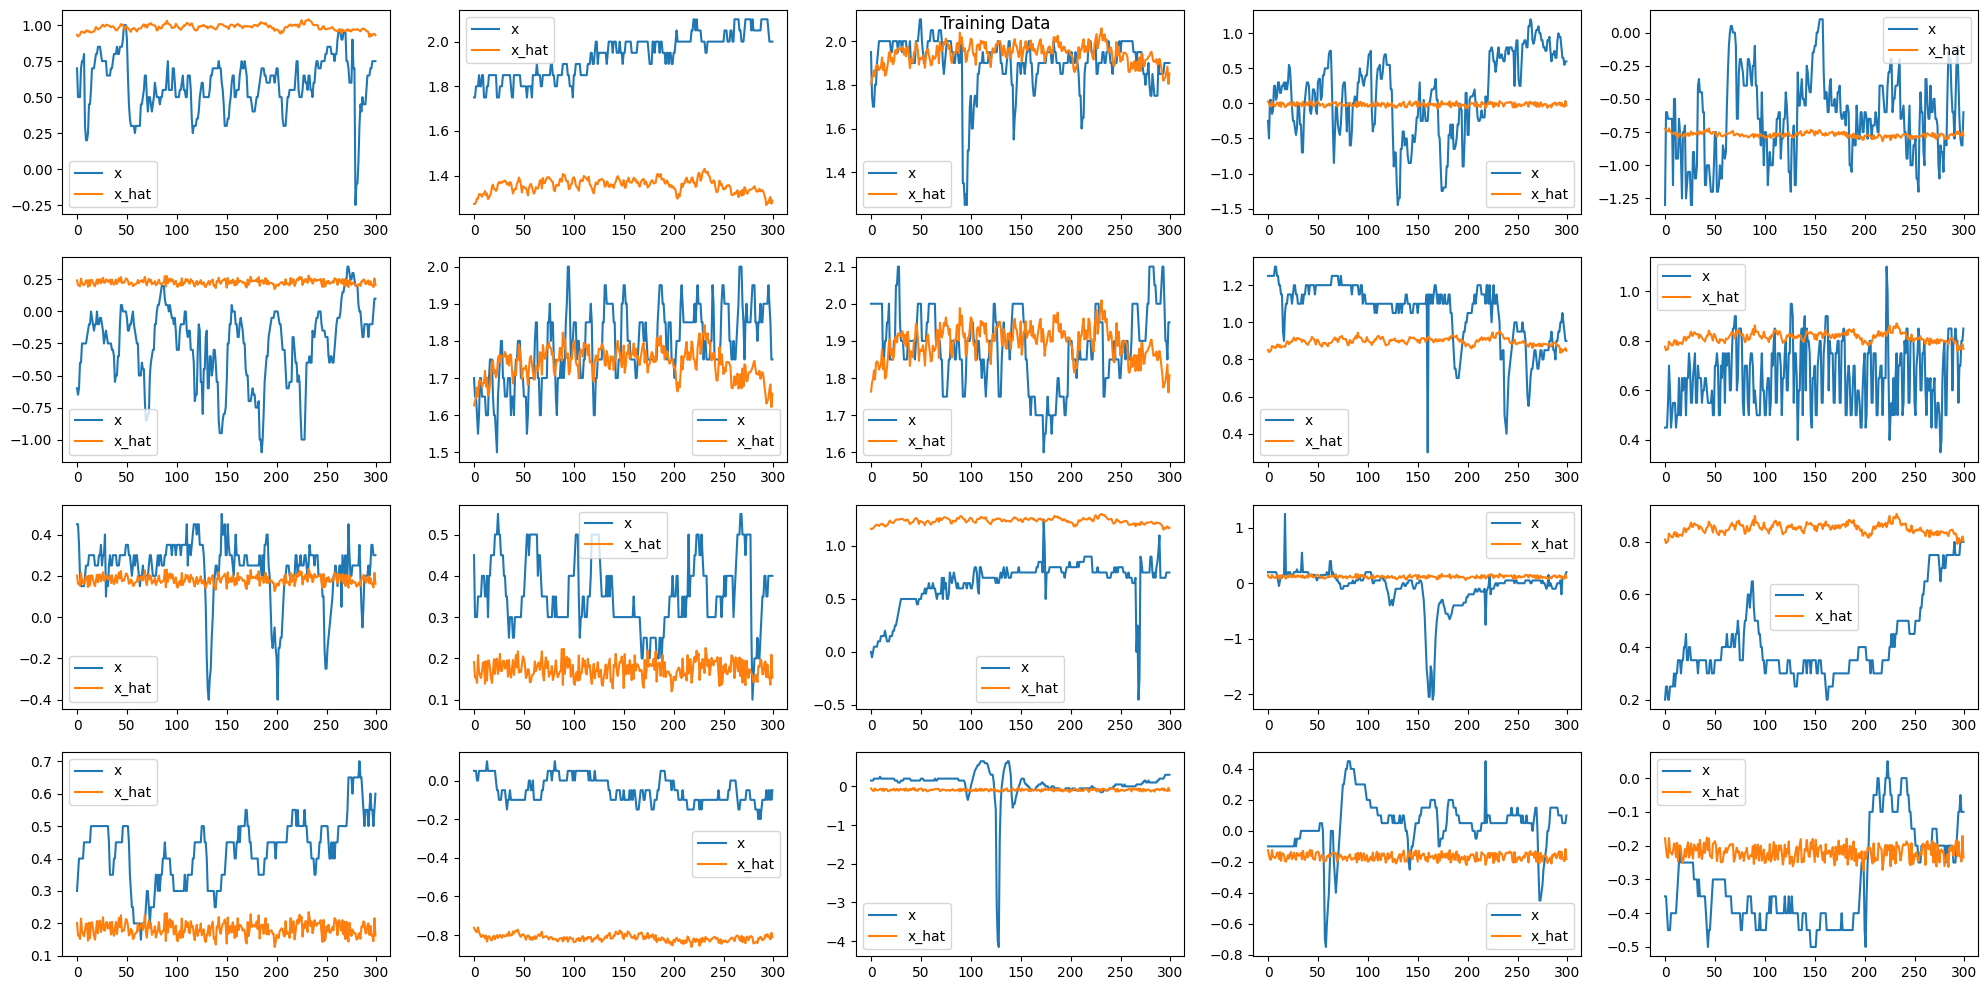

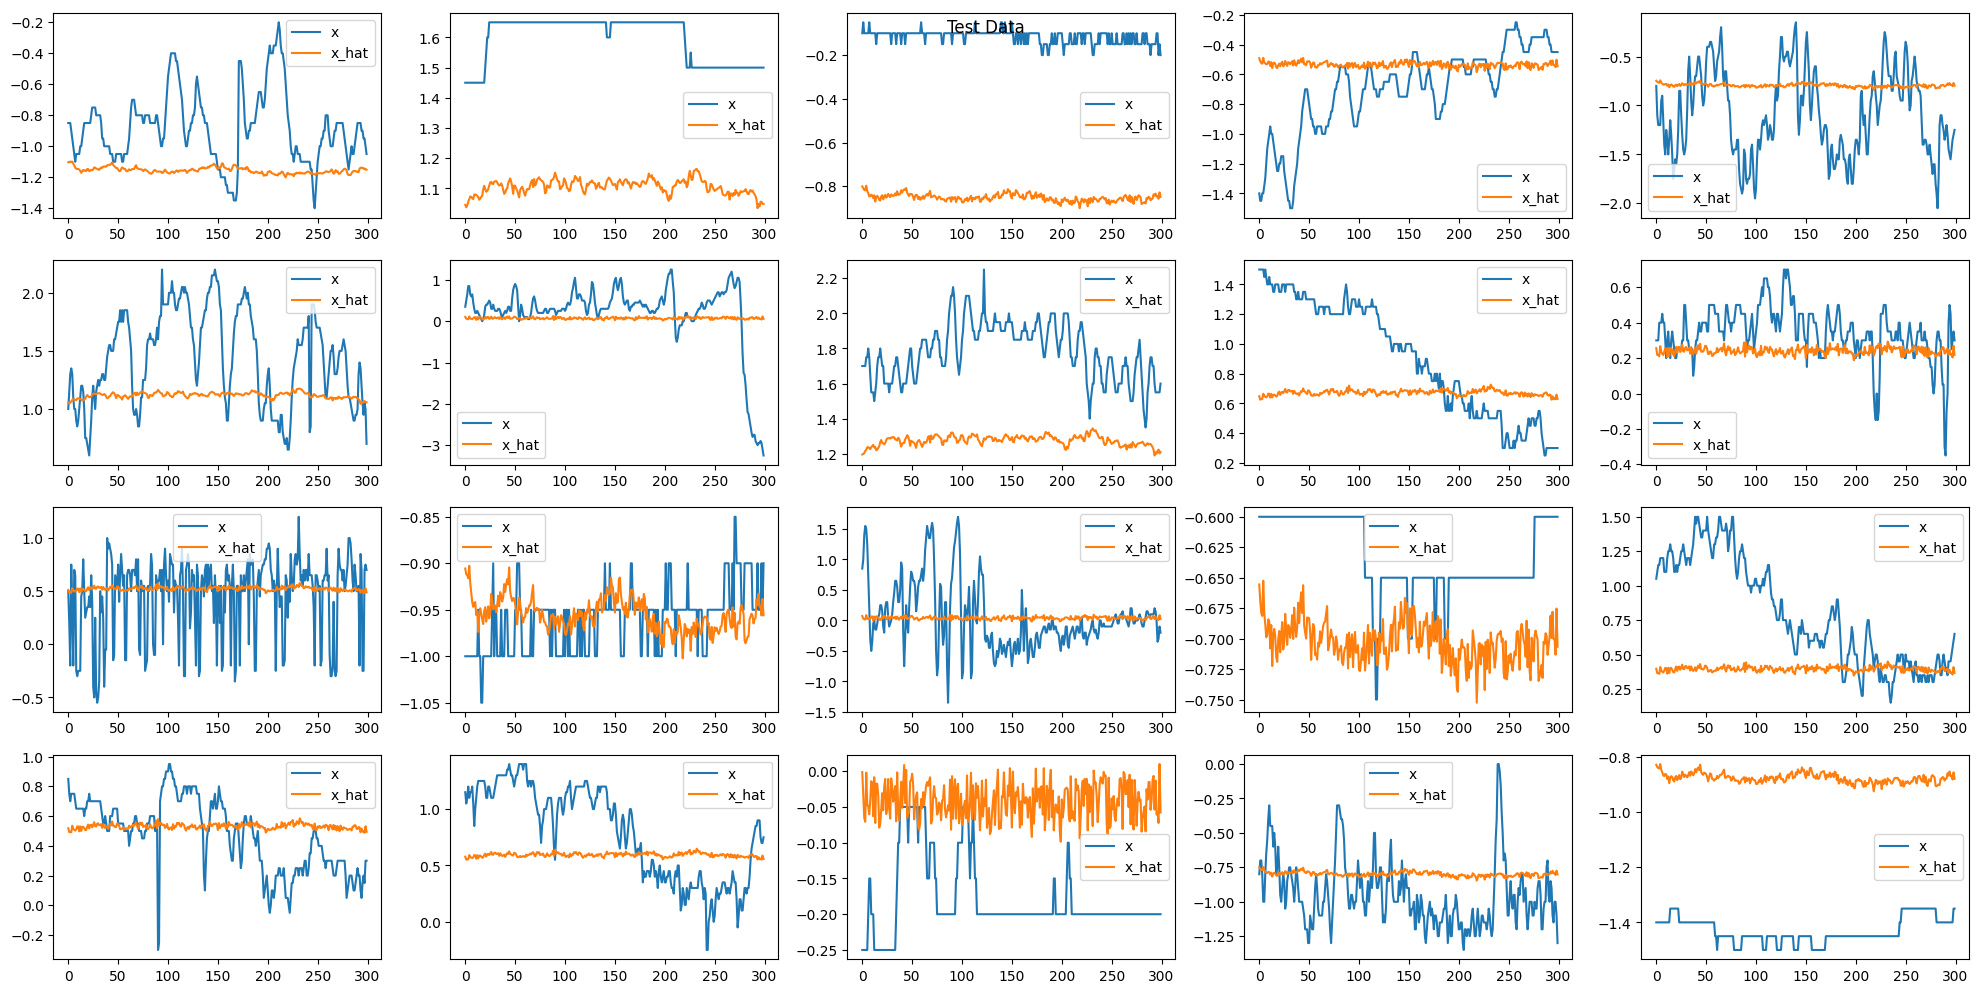

In [55]:
model.eval()
b = 0
fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = train_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
            
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()
fig.suptitle('Training Data')
plt.show()

fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(b, b+20):
    x, text_features, _ = test_dataloader.dataset[i]  # Assuming third element is labels
    x = x.unsqueeze(0).to(model.device)  # [1, ts_dim]
    text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]  # [1, text_dim]
    
    _, x_hat, mean, log_var = model(x, text_features)    
    axes[i//5, i%5].plot(x[0].cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat[0].cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()  
fig.suptitle('Test Data')
plt.show()


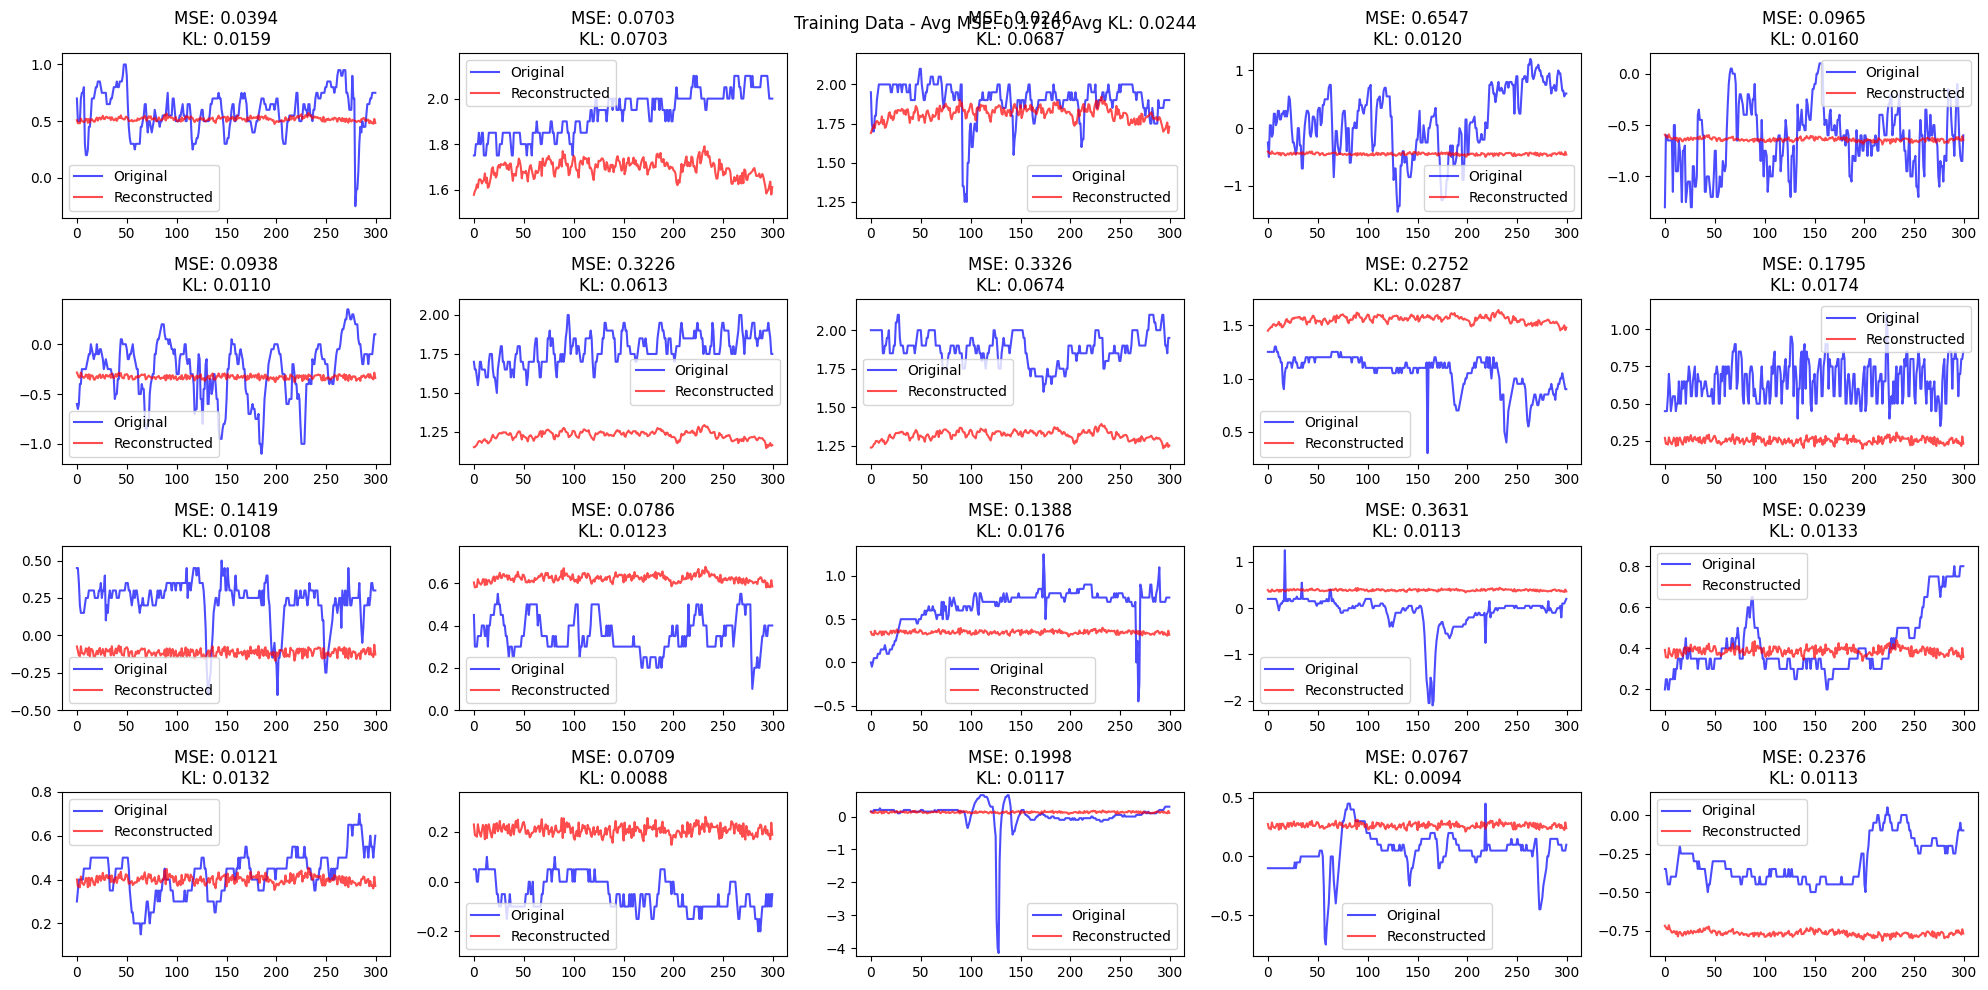

Statistics:
Average Reconstruction Loss: 0.1716
Average KL Loss: 0.0244
Min Reconstruction Loss: 0.0121
Max Reconstruction Loss: 0.6547


In [56]:
model.eval()
with torch.no_grad():  # Add this to prevent memory leaks
    b = 0
    fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
    
    # Add loss tracking
    recon_losses = []
    kl_losses = []
    
    for i in range(b, b+20):
        x, text_features, _ = train_dataloader.dataset[i]
        x = x.unsqueeze(0).to(model.device)
        text_features = [text_feature.unsqueeze(0).to(model.device) for text_feature in text_features]
        
        # Get model outputs
        _, x_hat, mean, log_var = model(x, text_features)
        
        # Calculate losses for this sample
        recon_loss = F.mse_loss(x_hat, x).item()
        kl_loss = -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp()).item()
        recon_losses.append(recon_loss)
        kl_losses.append(kl_loss)
        
        # Plot with more information
        ax = axes[i//5, i%5]
        ax.plot(x[0].cpu().numpy(), label='Original', color='blue', alpha=0.7)
        ax.plot(x_hat[0].cpu().numpy(), label='Reconstructed', color='red', alpha=0.7)
        ax.set_title(f'MSE: {recon_loss:.4f}\nKL: {kl_loss:.4f}')
        ax.legend()
        
        # Add y-axis limits to see full range
        y_min = min(x[0].cpu().min(), x_hat[0].cpu().min())
        y_max = max(x[0].cpu().max(), x_hat[0].cpu().max())
        ax.set_ylim([y_min-0.1, y_max+0.1])
        
    plt.tight_layout()
    fig.suptitle(f'Training Data - Avg MSE: {np.mean(recon_losses):.4f}, Avg KL: {np.mean(kl_losses):.4f}')
    plt.show()

    # Print statistics
    print("Statistics:")
    print(f"Average Reconstruction Loss: {np.mean(recon_losses):.4f}")
    print(f"Average KL Loss: {np.mean(kl_losses):.4f}")
    print(f"Min Reconstruction Loss: {np.min(recon_losses):.4f}")
    print(f"Max Reconstruction Loss: {np.max(recon_losses):.4f}")

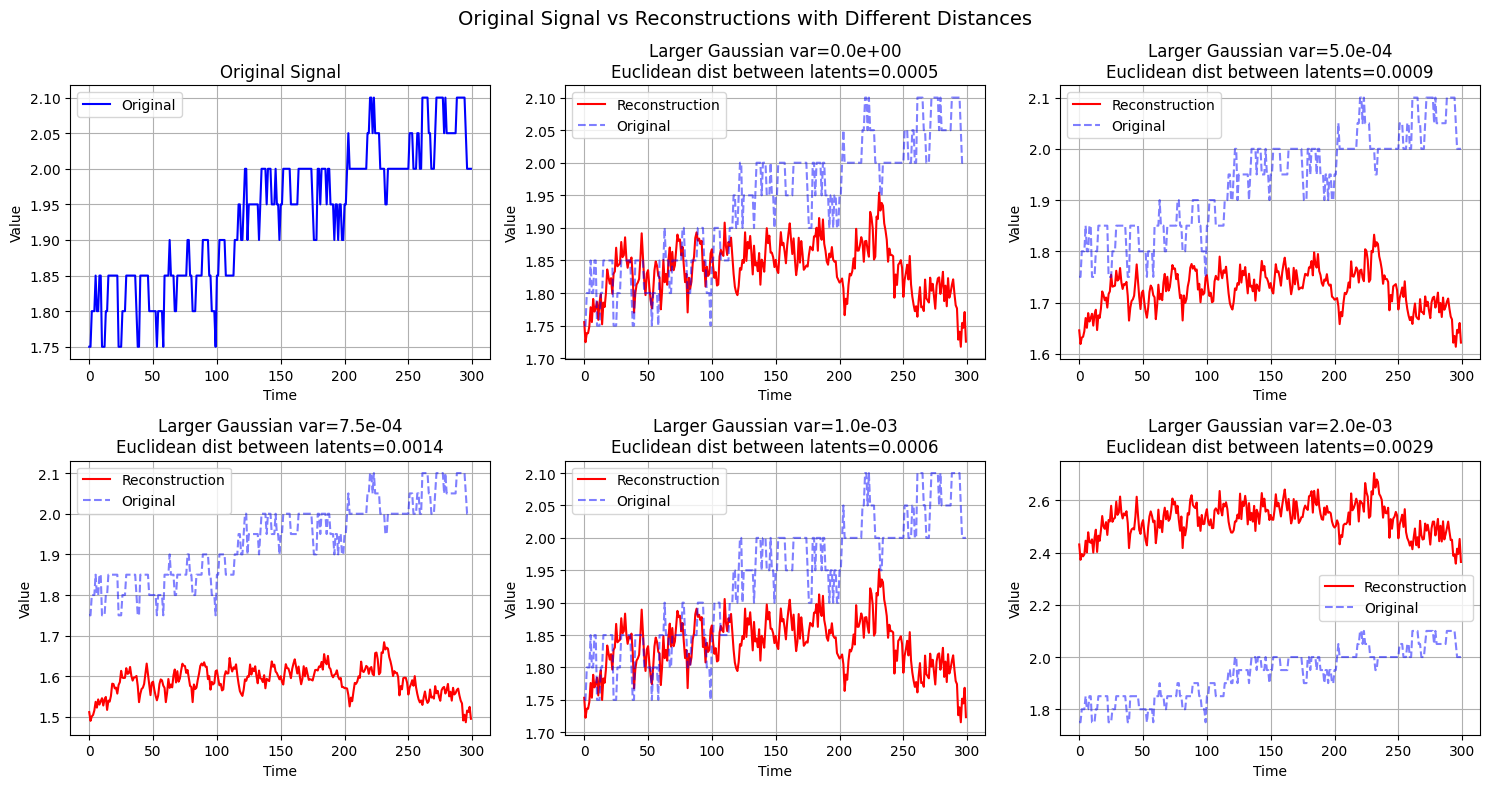

In [42]:
x, text_features, _ = train_dataloader.dataset[i]  # Assuming third element is labels
# _, x_hat, mean, log_var = model(x, text_features)  

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Original Signal vs Reconstructions with Different Distances', fontsize=14)

# Flatten axs for easier iteration
axs = axs.flatten()

# Plot original signal in first subplot
axs[0].plot(x.detach().numpy(), 'b-', label='Original')
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].grid(True)
axs[0].legend()

# Plot reconstructions with different distances
distances = [0, 5e-4, 7.5e-4, 1e-3, 2e-3]
for i, distance in enumerate(distances, 1):
    # Get embeddings and reconstruction
    z_true, z_mean, z_log_var = model.ts_encoder(x) 
    z = model.ts_encoder.reparameterization(z_mean, z_log_var + distance)
    x_hat = model.ts_decoder(z)
    _, z_mean_hat, z_log_var_hat = model.ts_encoder(x_hat)

    # Calculate Euclidean distance
    z_mean = z_mean.cpu().detach().numpy()
    z_mean_hat = z_mean_hat.cpu().detach().numpy()
    euc_dist = np.sqrt(np.sum((z_mean - z_mean_hat) ** 2))

    # Plot reconstruction
    axs[i].plot(x_hat.detach().numpy(), 'r-', label=f'Reconstruction')
    axs[i].plot(x.detach().numpy(), 'b--', alpha=0.5, label='Original')
    axs[i].set_title(f'Larger Gaussian var={distance:.1e}\nEuclidean dist between latents={euc_dist:.4f}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Test CLIP

## Test JOINT